<a href="https://colab.research.google.com/github/rqchao/cs182-project/blob/main/gpt_neox_qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

^C
ERROR: Operation cancelled by user


First let's load the model we are going to use - GPT-neo-x-20B! Note that the model itself is around 40GB in half precision

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4, 7"

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "EleutherAI/gpt-neox-20b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

/home/xzrderek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 46/46 [00:32<00:00,  1.43it/s]


Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [3]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [4]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [5]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8650752 || all params: 10597552128 || trainable%: 0.08162971878329976


In [6]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='data/spongebob_lines2.csv')
dataset = dataset.map(lambda samples: tokenizer(samples["SpongeBob Lines"]), batched=True)

In [7]:
import transformers

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

# device = torch.device("cuda")

r_list = [4, 8, 16]
lora_alpha_list = [16, 32, 64]
lora_dropout_list = [0.01, 0.05]

best_loss = 1000
best_losses = []
iterations = 0

for r in r_list:
    for lora_alpha in lora_alpha_list:
        for lora_dropout in lora_dropout_list:

            config = LoraConfig(
                r=r,
                lora_alpha=lora_alpha,
                target_modules=["query_key_value"],
                lora_dropout=lora_dropout,
                bias="none",
                task_type="CAUSAL_LM"
            )

            model = get_peft_model(model, config)
            print_trainable_parameters(model)

            # needed for gpt-neo-x tokenizer
            tokenizer.pad_token = tokenizer.eos_token

            trainer = transformers.Trainer(
                model=model,
                train_dataset=dataset["train"],
                args=transformers.TrainingArguments(
                    per_device_train_batch_size=1,
                    gradient_accumulation_steps=4,
                    warmup_steps=2,
                    max_steps=10,
                    learning_rate=2e-4,
                    fp16=True,
                    logging_steps=1,
                    output_dir="outputs",
                    optim="paged_adamw_8bit"
                ),
                data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
            )
            model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
            trainer.train()

            # print(trainer.state.log_history)

            losses = []

            for log in trainer.state.log_history:
                if 'loss' in log:
                    losses.append(log['loss'])

            # print(losses)

            iterations += 1

            if losses[-1] < best_loss:
                best_r, best_lora_alpha, best_lora_dropout = r, lora_alpha, lora_dropout   
                best_losses = losses

            if iterations >= 5:
                break

print("Best r value: " + str(best_r))
print("Best lora_alpha value: " + str(best_lora_alpha))
print("Best lora_dropout value: " + str(best_lora_dropout))
print("Final Loss: " + str(best_loss))


plt.title("Grid Search Finetuning: Best training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(best_losses)), best_losses, color ="red")
plt.legend()
plt.show()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable params: 4325376 || all params: 10593226752 || trainable%: 0.04083152472105225


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/xzrderek/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'loss': 4.0284, 'learning_rate': 0.0001, 'epoch': 0.0, 'step': 1}, {'loss': 4.6069, 'learning_rate': 0.0002, 'epoch': 0.0, 'step': 2}, {'loss': 4.2995, 'learning_rate': 0.00019795918367346938, 'epoch': 0.0, 'step': 3}, {'loss': 3.1777, 'learning_rate': 0.0001959183673469388, 'epoch': 0.0, 'step': 4}, {'loss': 3.777, 'learning_rate': 0.00019387755102040816, 'epoch': 0.0, 'step': 5}, {'loss': 3.4194, 'learning_rate': 0.00019183673469387756, 'epoch': 0.0, 'step': 6}, {'loss': 3.0763, 'learning_rate': 0.00018979591836734697, 'epoch': 0.0, 'step': 7}, {'loss': 3.6489, 'learning_rate': 0.00018775510204081634, 'epoch': 0.0, 'step': 8}, {'loss': 3.3619, 'learning_rate': 0.00018571428571428572, 'epoch': 0.0, 'step': 9}, {'loss': 2.6703, 'learning_rate': 0.00018367346938775512, 'epoch': 0.0, 'step': 10}, {'loss': 3.1165, 'learning_rate': 0.0001816326530612245, 'epoch': 0.0, 'step': 11}, {'loss': 3.0387, 'learning_rate': 0.0001795918367346939, 'epoch': 0.0, 'step': 12}, {'loss': 3.1093, 'learni

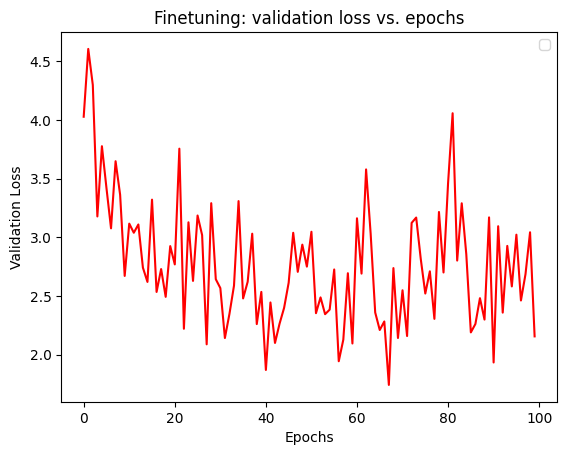

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

print(trainer.state.log_history)

losses = []

for log in trainer.state.log_history:
    if 'loss' in log:
        losses.append(log['loss'])

# print(losses)

plt.title("Finetuning: training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(losses)), losses, color ="red")
plt.legend()
plt.show()

In [ ]:
# Iterating over all parameters of the model. In deep learning models, parameters are the parts of the model that are learned from the training data, such as weights.
for parameter in model.parameters():
    # Freezing the parameter. This means that this parameter will not be updated during training.
    # This is done to keep the pre-trained knowledge intact while we fine-tune only certain parts of the model.
    parameter.requires_grad = False

# Transformer models are typically composed of several layers (or blocks) stacked on top of each other.
for i, m in enumerate(model.transformer.h):
    # Checking if the current block is one of the last 'n' blocks.
    # 'config['UNFREEZE_LAST_N']' specifies how many of the last blocks should be unfrozen.

    if i + 1 > 12 - config['UNFREEZE_LAST_N']:
        for parameter in m.parameters():
            # Unfreezing is done so that these parameters can be updated during training.
            parameter.requires_grad = True 

# Unfreezing the parameters of the layer normalization at the end of the transformer.
for parameter in model.transformer.ln_f.parameters():
    parameter.requires_grad = True

# Unfreezing the parameters of the language model head. The 'lm_head' is typically the output layer of the model.
for parameter in model.lm_head.parameters():
    parameter.requires_grad = True


# Utilize best hyperparameters from grid search from above.
config = LoraConfig(
    r=best_r,
    lora_alpha=best_lora_alpha,
    target_modules=["query_key_value"],
    lora_dropout=best_lora_dropout,
    bias="none",
    task_type="CAUSAL_LM"
)


trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [19]:
input_text = "You are Spongebob. What is Patrick's relation to you?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate a response
output = model.generate(input_ids=input_ids, max_length=30, num_return_sequences=1)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated text: " + str(generated_text))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/xzrderek/.local/lib/python3.11/site-packages/transformers/generation/utils.py:1591: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/home/xzrderek/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in t

Generated text: You are Spongebob. What is Patrick's relation to you? Patrick: I'm Patrick's brother. Patrick: Patrick's brother? Patrick:
